In [45]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

In [46]:
data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [47]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [48]:
cols = ['Pclass', 'Name', 'Sex', 'Age', 'SibSp','Parch', 'Fare', 'Embarked','Cabin']

In [49]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [50]:
# Define function to extract titles from passenger names
def get_title(name):
            title_search = re.search(' ([A-Za-z]+)\.', name)
            # If the title exists, extract and return it.
            if title_search:
                return title_search.group(1)
            return ""

In [51]:
#.loc[row_indexer,col_indexer]
def preproc_data(XX, cc, nc):

    if('Name') in XX.columns:
    
        
        # Create a new feature Title, containing the titles of passenger names
        XX.loc[:,'Name'] = XX['Name'].apply(get_title)
        # Group all non-common titles into one single grouping "Rare"
        XX.loc[:,'Name'] = XX['Name'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                                     'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

        XX.loc[:,'Name'] = XX['Name'].replace('Mlle', 'Miss')
        XX.loc[:,'Name'] = XX['Name'].replace('Ms', 'Miss')
        XX.loc[:,'Name'] = XX['Name'].replace('Mme', 'Mrs')
    
    if('Age') in XX.columns:
        age = XX[['Pclass','Age']].groupby(by='Pclass').median()
        XX.loc[:,'Age'] = [age.loc[XX.Pclass[i]].values[0] if pd.isna(XX.Age[i]) else XX.Age[i] 
                    for i in XX[['Pclass', 'Age']].index]
        ## create bin for age features
        #XX.loc[:,'Age_bin'] = pd.cut(XX['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])
        #cc.append('Age_bin')
        #nc.remove('Age')

    if('Fare') in XX.columns:
        XX.loc[:,'Fare'].fillna(XX['Fare'].mean(),inplace=True)
        
        ## create bin for fare features
        ##XX.loc[:,'Fare_bin'] = pd.cut(XX['Fare'], bins=[0,7.91,14.45,31,120], 
                               #labels=['Low_fare','median_fare','Average_fare','high_fare'])
        ##cc.append('Fare_bin')
        ##nc.remove('Fare')
        
    
    if('Embarked') in XX.columns:
        emb = pd.Series(Counter(XX.Embarked))
        XX.loc[:,'Embarked'].fillna(emb.idxmax(),inplace=True)

    
    if ('SibSp' in  XX.columns) & ('Parch' in  XX.columns):
        XX.loc[:,'FamilySize'] = XX['SibSp'] + XX['Parch'] + 1
        nc.append('FamilySize')
        
    if ('Cabin') in XX.columns:
        #XX["Cabin_Data"] = XX["Cabin"].isnull().apply(lambda x: not x)
        XX["Room"] = XX["Cabin"].str.slice(1,5).str.extract("([0-9]+)", expand=False).astype("float")
        XX["Cabin"] = XX["Cabin"].str.slice(0,1)
        XX["Cabin"] = XX["Cabin"].fillna("N")
        XX["Room"] = XX["Room"].fillna(XX["Room"].mean())
        nc.append('Room')
        
    if(len(cc)>0):
        cat = pd.get_dummies(XX[cc])
        return pd.concat((XX[nc],cat),axis=1)
    else:
        return XX[nc]
    

In [52]:
#build model
y = data['Survived']
X = data[cols]
X.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,NaN
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,C85
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,NaN
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,C123
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,NaN


In [53]:
F = preproc_data(X, ['Sex','Name','Embarked','Cabin'],['Pclass','Age','SibSp','Parch','Fare'])
F.head()

/home/vasylcf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/vasylcf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/vasylcf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

,Pclass,Age,SibSp,Parch,Fare,FamilySize,Room,Sex_female,Sex_male,Name_Master,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Cabin_T
0,3,22.0,1,0,7.2500,2,50.49,0,1,0,...,1,0,0,0,0,0,0,0,1,0
1,1,38.0,1,0,71.2833,2,85.00,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3,26.0,0,0,7.9250,1,50.49,1,0,0,...,1,0,0,0,0,0,0,0,1,0
3,1,35.0,1,0,53.1000,2,123.00,1,0,0,...,1,0,0,1,0,0,0,0,0,0
4,3,35.0,0,0,8.0500,1,50.49,0,1,0,...,1,0,0,0,0,0,0,0,1,0


In [54]:
def compare_cols(a,b):
    fill_cols = list((set(a)^set(b))&set(a))
    for c in fill_cols:
        b[c]=np.zeros(b.shape[0])
    drop_cols = list((set(a)^set(b))&set(b))
    if len(drop_cols)>0:
        for d in drop_cols:
            b=b.drop(d,axis=1)
    return b

In [55]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(F,y,test_size=0.2, random_state=20)

In [62]:
X_train.columns

Index(['Age', 'SibSp', 'Fare', 'Parch', 'Pclass', 'FamilySize', 'Room',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_N', 'Cabin_T', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Name_Master', 'Name_Miss', 'Name_Mr',
       'Name_Mrs', 'Name_Rare'],
      dtype='object')

In [56]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
train_acc = model_selection.cross_val_score(clf, X_train, y_train, cv=3).mean()
print(f'train_acc: {train_acc}')
test_acc = model_selection.cross_val_score(clf, X_test, y_test, cv=3).mean()
print(f'test_acc: {test_acc}')

train_acc: 0.8174405355362483
test_acc: 0.8602389552653514


/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

In [58]:
cols

['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin']

In [59]:
cat_cols = ['Sex','Embarked','Name','Cabin']
num_cols = ['Pclass','Age','Fare','SibSp','Parch']

In [76]:
acc_hist=[]
acc_test_hist=[]
cols_hist=[]
for c in range(1,len(cols)+1):
    categorical = list(set(cols[:c])&set(cat_cols))
    numerical = list(set(cols[:c])&set(num_cols))
    X = data[cols[:c]]
    F = preproc_data(X, categorical, numerical)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(F,y,test_size=0.2, random_state=20)
    clf = LogisticRegression(penalty='l1')
    clf.fit(X_train, y_train)
    train_acc = model_selection.cross_val_score(clf, X_train, y_train, cv=3).mean()
    print(f'#features: {cols[:c]}, train_acc: {train_acc}')
    test_acc = model_selection.cross_val_score(clf, X_test, y_test, cv=3).mean()
    print(f'test_acc: {test_acc}')
    
    acc_hist.append(train_acc)
    acc_test_hist.append(test_acc)

/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

#features: ['Pclass'], train_acc: 0.6769572235673932
test_acc: 0.6867648420857645
#features: ['Pclass', 'Name'], train_acc: 0.778129896026207
test_acc: 0.8042974900435306
#features: ['Pclass', 'Name', 'Sex'], train_acc: 0.7823434458529174
test_acc: 0.8325460776141521
#features: ['Pclass', 'Name', 'Sex', 'Age'], train_acc: 0.7908180221241038
test_acc: 0.8325460776141521


/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

#features: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp'], train_acc: 0.8146275459336277
test_acc: 0.8436602760025934
#features: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch'], train_acc: 0.818864834069221
test_acc: 0.8436602760025934
#features: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'], train_acc: 0.8090253050372692
test_acc: 0.8491247568769102
#features: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], train_acc: 0.8132507240184209
test_acc: 0.8380105584884691
#features: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin'], train_acc: 0.8160518444666002
test_acc: 0.8380105584884691


/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/vasylcf/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/

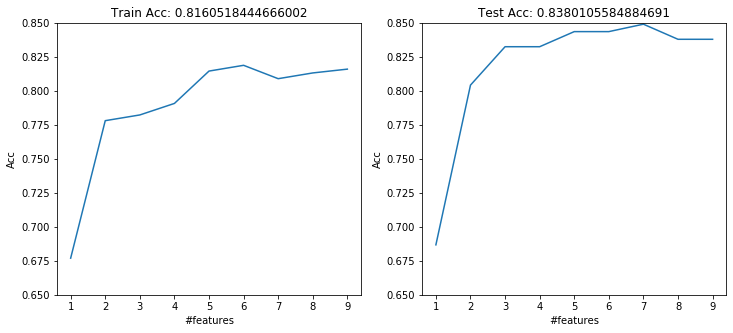

In [77]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title(f'Train Acc: {acc_hist[-1]}')
plt.xlabel('#features')
plt.ylabel('Acc')
plt.ylim(0.65,.85)
plt.plot(range(1,len(acc_hist)+1),acc_hist)
plt.subplot(1,2,2)
plt.title(f'Test Acc: {acc_test_hist[-1]}')
plt.xlabel('#features')
plt.ylabel('Acc')
plt.ylim(0.65,.85)
plt.plot(range(1,len(acc_test_hist)+1),acc_test_hist)

In [ ]:
X_train.head()

In [ ]:
X_train.columns

## Validation

In [ ]:
test.columns

In [65]:
test[cols].head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin
0,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,NaN
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,NaN
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,NaN
3,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,NaN
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,NaN


In [66]:
valid  = preproc_data(test[cols],['Sex','Embarked','Name','Cabin'],['Pclass','Age','Fare','SibSp','Parch'])

/home/vasylcf/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/vasylcf/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [67]:
valid.columns

Index(['Pclass', 'Age', 'Fare', 'SibSp', 'Parch', 'FamilySize', 'Room',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Name_Master', 'Name_Miss', 'Name_Mr', 'Name_Mrs', 'Name_Rare',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_N'],
      dtype='object')

In [73]:
valid.shape

(418, 26)

In [70]:
set(F.columns)^set(valid.columns)

{'Cabin_T'}

In [71]:
valid = compare_cols(F,valid)

In [69]:
F.shape

(891, 26)

In [74]:
preditions = clf.predict(valid)
submission = pd.DataFrame(columns=['PassengerId','Survived'])
submission.PassengerId = test.PassengerId
submission.Survived = preditions
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [75]:
# score: 74
submission.to_csv('features_final.csv', index=False)